# Import Library

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB

# Start

In [ ]:
data = pd.read_csv('genz_2.csv')
data

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,1839077965877096552,Wed Sep 25 23:02:10 +0000 2024,0,Kalau ngomongin generasi gue juga Gen Z. Tapi ...,1839077968037163408,NaN,13tylr,in,"Khon Kaen, Thailand",0,0,0,https://x.com/13tylr/status/1839077968037163408,1591492173790605312,13tylr
1,1838856480579285290,Wed Sep 25 21:29:45 +0000 2024,0,@folkshittmedia Blm tau rasa di strict parents...,1839054708792766780,NaN,folkshittmedia,in,NaN,0,0,0,https://x.com/failandup/status/183905470879276...,1643773164395315203,failandup
2,1839050308439388624,Wed Sep 25 21:12:16 +0000 2024,0,Btw gak cuman 'gen z' yg gasuka di chat malem-...,1839050308439388624,NaN,NaN,in,mdni,0,1,0,https://x.com/uappilion/status/183905030843938...,767473388839329792,uappilion
3,1839023925826826667,Wed Sep 25 19:27:25 +0000 2024,0,bntar bntar anak 18 tahun bisa pny limit payla...,1839023925826826667,NaN,NaN,in,antenor,0,3,0,https://x.com/thatswasntme/status/183902392582...,3179102491,thatswasntme
4,1838999824378790085,Wed Sep 25 17:51:39 +0000 2024,0,Ini aku kebangun gr2 ditelpon tmpt krjaa cuman...,1838999824378790085,NaN,NaN,in,indonesia,0,0,0,https://x.com/bikinikills_/status/183899982437...,1486665020,bikinikills_
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506,1806909343104639476,Sun Jun 30 00:13:06 +0000 2024,0,@26wib inilah tmsk 1 dr 10 jt gen Z yg gak mau...,1807205684771176847,NaN,26wib,in,Jakarta,0,0,0,https://x.com/Dedy44169434/status/180720568477...,1006840774502146049,Dedy44169434
2507,1807200181194223780,Sat Jun 29 23:51:14 +0000 2024,0,Gen Z merupakan mereka yang tumbuh besar denga...,1807200181194223780,https://pbs.twimg.com/media/GRPneXPaAAEjW67.jpg,NaN,in,"Kelapa Gading, North Jakarta",0,1,0,https://x.com/majalahsunday/status/18072001811...,180240682,majalahsunday
2508,1807108661455774055,Sat Jun 29 17:47:34 +0000 2024,0,Begini Cara Bikin GenZ Kerja Keras https://t.c...,1807108661455774055,NaN,NaN,in,Indonesia,0,0,0,https://x.com/dellov/status/1807108661455774055,126607693,dellov
2509,1807074232783839507,Sat Jun 29 16:52:58 +0000 2024,0,@bennysiauw89 @NarasiNewsroom Mantap kerja ker...,1807094921389818101,NaN,bennysiauw89,in,"Bali, Indonesia",0,0,0,https://x.com/djaranmati/status/18070949213898...,1115513696728616960,djaranmati


In [ ]:
data = data[['full_text', 'username']]
data.sample()

,full_text,username
1211,dari semua gen z menguasai dunia (masuk dunia ...,derwomm


# 1. Data Understanding

In [ ]:
data.dtypes

,0
full_text,object
username,object


In [ ]:
data.shape

(2511, 2)

In [ ]:
# Hapus duplikat
data = data.drop_duplicates(subset=['full_text'])
data.duplicated().sum()

0

In [ ]:
# Hapus dan cek data kosong
data = data.dropna()
data.isnull().sum()

,0
full_text,0
username,0


In [ ]:
data.shape

(2498, 2)

In [ ]:
# Reset indeks agar berurutan
data.reset_index(drop=True, inplace=True)

# Cek lagi ukuran dan indeks setelah reset
print("Ukuran setelah reset indeks:", data.shape)
print(data.tail(10))

Ukuran setelah reset indeks: (2498, 2)
                                              full_text        username
2488  @Pejuangmslim @Jateng_Twit Aplgi yg katanya sk...    dionwiyoko56
2489  @worksfess Ini kendala gw punya bawahan di gen...  AsyadiIndrawan
2490  2. Impor membunuh industri nasional tmpt org c...  dancersejati07
2491  1. BPS: Pada 2023 sekitar 9 9 juta penduduk us...  dancersejati07
2492  @BudiBukanIntel @ritusmusimsemi Si kacrut oran...   txtdarigenzee
2493  @26wib inilah tmsk 1 dr 10 jt gen Z yg gak mau...    Dedy44169434
2494  Gen Z merupakan mereka yang tumbuh besar denga...   majalahsunday
2495  Begini Cara Bikin GenZ Kerja Keras https://t.c...          dellov
2496  @bennysiauw89 @NarasiNewsroom Mantap kerja ker...      djaranmati
2497  Gen Z merupakan mereka yang tumbuh besar denga...   majalahsunday


# 2. Preprocessing

## a. Data Cleaning

In [ ]:
def clean_twitter_text(text):
    # Hapus mention
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    # Hapus tagar
    text = re.sub(r'#\w+', '', text)
    # Hapus retweet
    text = re.sub(r'RT[\s]+', '', text)
    # Hapus link atau URL
    text = re.sub(r'https?://\S+', '', text)
    # Hapus simbol khusus tetapi biarkan huruf, angka, dan spasi
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

data['full_text'] = data['full_text'].apply(clean_twitter_text)
data.head(3)

,full_text,username
0,Kalau ngomongin generasi gue juga Gen Z Tapi s...,13tylr
1,Blm tau rasa di strict parents wlpn unir mau 2...,failandup
2,Btw gak cuman gen z yg gasuka di chat malemmal...,uappilion


## b. Case Folding

In [ ]:
# Ubah menjadi lower case
data = data.copy()
data['full_text'] = data['full_text'].str.lower()
data.head(3)

,full_text,username
0,kalau ngomongin generasi gue juga gen z tapi s...,13tylr
1,blm tau rasa di strict parents wlpn unir mau 2...,failandup
2,btw gak cuman gen z yg gasuka di chat malemmal...,uappilion


## c. Normalisasi

In [ ]:
# Ubah kata yang disingkat menjadi normal dan baku
norm = {' yg ':' yang ', ' jg ':' juga ', ' bgt ':' banget ', ' dgn ':' dengan ', ' bbrp ':' beberapa ', 'blm ':' belum ',
        ' cmn ':' cuma ', ' pd ':' pada ', ' tp ':' tapi ', ' hrs ':' harus ', ' lgsg ':' langsung ', ' trs ':' terus ',
        ' byk ':' banyak ', ' udh ':' sudah ', ' bs ':' bisa ', ' sgt ':' sangat ', ' gk ':' tidak ', ' gpp ':' tidak apa-apa ',
        ' jd ':' jadi ', ' ttg ':' tentang ', ' km ':' kamu ', ' tmpt ':' tempat ', ' mrk ':' mereka ', ' pen ':'  ingin ',
        ' emg ':' memang ', ' dg ':' dengan ', ' blm ':' belum ', ' bygin ':' bayangkan ', ' org ':' orang ', ' pgn ':' ingin ',
        ' nnti ':' nanti ', ' dr ':' dari ', ' skrg ':' sekarang ', ' bkn ':' bikin ', ' klo ':' kalau ', ' gk ':' tidak ',
        ' mcm ':' macam ', ' pke ':' pakai ', ' ga ':' tidak ', ' krn ':' karena ', ' cwe ':' cewek ', ' ni ':' ini ', ' knp ':' kenapa ',
        ' spt ':' seperti ', ' ak ':' aku ', ' pdhl ':' padahal ', ' rek ':' rekening ', ' cwo ':' cowok ', ' tmsk ':' termasuk ',
        ' plz ':' please ', ' pls ':' please ', 'gt ':' begitu ', ' sm ':' sama ', ' kmrn ':' kemarin ', ' dpt ':' dapat ',
        ' wlpn ':' walaupun ', ' trus ':' terus ', ' gw ':' aku ', ' gua ':' aku ', ' gue ':' aku ', ' lo ':' kamu ',
        ' lu ':' kamu ', ' bntar ':' bentar ', ' stiap ':' setiap '}

def normalisasi(str_text):
  for i in norm:
    str_text = str_text.replace(i, norm[i])
  return str_text

data['full_text'] = data['full_text'].apply(lambda x: normalisasi(x))
data.head(3)

,full_text,username
0,kalau ngomongin generasi aku juga gen z tapi s...,13tylr
1,belum tau rasa di strict parents walaupun uni...,failandup
2,btw gak cuman gen z yang gasuka di chat malemm...,uappilion


## d. Stopword Removal

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 2.6 MB/s eta 0:00:00


In [ ]:
# Hilangkan kata tidak berbobot
import Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
more_stop_words = []

stop_words = StopWordRemoverFactory().get_stop_words()
new_array = ArrayDictionary(stop_words)
stop_words_remover_new = StopWordRemover(new_array)

def stopword(str_text):
  str_text = stop_words_remover_new.remove(str_text)
  return str_text

data['full_text'] = data['full_text'].apply(lambda x: stopword(x))
data.head(3)

,full_text,username
0,kalau ngomongin generasi aku gen z sumpah kamu...,13tylr
1,tau rasa strict parents walaupun unir mau 25 ...,failandup
2,btw gak cuman gen z gasuka chat malemmalem wkw...,uappilion


## e. Tokenisasi

In [ ]:
# Memisahkan kata dari kalimat
tokenized = data['full_text'].apply(lambda x:x.split())
tokenized.head(3)

,full_text
0,"[kalau, ngomongin, generasi, aku, gen, z, sump..."
1,"[tau, rasa, strict, parents, walaupun, unir, m..."
2,"[btw, gak, cuman, gen, z, gasuka, chat, malemm..."


## f. Stemming

In [ ]:
# Mengubah kata imbuhan menjadi kata dasar
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def stemming(text_cleaning):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  do = []
  for w in text_cleaning:
    dt = stemmer.stem(w)
    do.append(dt)
  d_clean = []
  d_clean = " ".join(do)
  print(d_clean)
  return d_clean

tokenized = tokenized.apply(stemming)
tokenized.to_csv('genz2_stemming.csv', index=False)
data_clean = pd.read_csv('genz2_stemming.csv', encoding='latin1')


kalau ngomongin generasi aku gen z sumpah kamu liat meja area kerja aku serap apa mah aja jorok anjoy
tau rasa strict parents walaupun unir mau 25 udah kerja udah mandiri wkwk tu anak makin barbar mental anak zaman sekarang kenapaya aku gen z aja banyak mikir buat
btw gak cuman gen z gasuka chat malemmalem wkwkwk atas aku jatohnya baby boomer aja kesel email jam 5 subuh krna tutup sama email kerja lain ibarat kamu mau naro cv kamu taro jam kantor biar lihat sama hrd nya dri situ aja hrusnya ngeh
bntar bentar anak 18 tahun pny limit paylater 11jt ojk gaada regulasi ketat buat begini memang sengaja bodoh massal biar semua wn gen z punya habit kerja buat bayar tagih kalo iya sumpah jahat banget gws
aku bangun gr2 telpon tempat krjaa cuman nanya bocah lahir 2000an gen z bikin ulah anjing jaman sekarang tuh nyusahin banget kerja sama anak gen z
gen z tiap abis kerja butuh self reward memang benar ada
aku tadi pas tempat kerja kamu lahir tahun berapa 2000 mba arti generasi apa millenial kan 

In [ ]:
data_clean.tail()

,full_text
2493,ini masuk 1 10 jt gen z gak mau kerja lbh neng...
2494,gen z rupa tumbuh besar teknologi digital inte...
2495,begini cara bikin genz kerja keras lewat
2496,mantap kerja kerja gen z
2497,gen z rupa tumbuh besar teknologi digital inte...


In [ ]:
# Untuk menambahkan kembali kolom username
t1 = pd.read_csv('genz_2.csv')
t2 = pd.read_csv('genz2_stemming.csv')
tgab = t1['username']

data_clean = pd.concat([t2, tgab], axis=1)
data_clean

,full_text,username
0,kalau ngomongin generasi aku gen z sumpah kamu...,13tylr
1,tau rasa strict parents walaupun unir mau 25 u...,failandup
2,btw gak cuman gen z gasuka chat malemmalem wkw...,uappilion
3,bntar bentar anak 18 tahun pny limit paylater ...,thatswasntme
4,aku bangun gr2 telpon tempat krjaa cuman nanya...,bikinikills_
...,...,...
2506,NaN,Dedy44169434
2507,NaN,majalahsunday
2508,NaN,dellov
2509,NaN,djaranmati


In [ ]:
# Cleaning data NaN
data_clean = data_clean.dropna()
data_clean.to_csv('genz2_clean.csv')
data_clean

,full_text,username
0,kalau ngomongin generasi aku gen z sumpah kamu...,13tylr
1,tau rasa strict parents walaupun unir mau 25 u...,failandup
2,btw gak cuman gen z gasuka chat malemmalem wkw...,uappilion
3,bntar bentar anak 18 tahun pny limit paylater ...,thatswasntme
4,aku bangun gr2 telpon tempat krjaa cuman nanya...,bikinikills_
...,...,...
2493,ini masuk 1 10 jt gen z gak mau kerja lbh neng...,bethalfagamma
2494,gen z rupa tumbuh besar teknologi digital inte...,ThreadGen_Z
2495,begini cara bikin genz kerja keras lewat,dorramaturgy
2496,mantap kerja kerja gen z,addictothemoon


# 3. Labeling

## 3.1. Labeling Sentimen

1.   Labeling dilakukan secara manual dan menghasilkan file 'genz2_manuallabel.csv'
2.   Labeling dilakukan secara otomatis menghasil file 'genz2_autolabel.csv'

In [ ]:
data = pd.read_csv('genz2_clean.csv', index_col=0)
data.tail()

,full_text,username
2493,ini masuk 1 10 jt gen z gak mau kerja lbh neng...,bethalfagamma
2494,gen z rupa tumbuh besar teknologi digital inte...,ThreadGen_Z
2495,begini cara bikin genz kerja keras lewat,dorramaturgy
2496,mantap kerja kerja gen z,addictothemoon
2497,gen z rupa tumbuh besar teknologi digital inte...,ArsitaAkbar


In [ ]:
!pip install transformers
!pip install googletrans==3.1.0a0

from googletrans.client import Translator
translator = Translator()

from transformers import pipeline
sentiment_classifier = pipeline('sentiment-analysis')

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.1 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16352 sha256=b6ce1015e28696b521d9e057782c6f22ac9621ea8077c4268c8906f638d78a4d
  Stored in directory: /root/.cache/pip/wheels/50/5d/3c/8477d0af4ca2b8b1308812c09f1930863caeebc762fe265a95
Successfully built googletrans
  Attempting uninstall: h11
    Found existing installation: h11 0.14.0
    Uninstalling h11-0.14.0:
      Succe

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
data['label'] = data['full_text'].str.encode('ascii','ignore').apply(translator.translate, dest='en')
data['label'] = data['label'].apply(getattr, args=('text',))
data.tail()

,full_text,username,label
2493,ini masuk 1 10 jt gen z gak mau kerja lbh neng...,bethalfagamma,"b'this is entering 1 10 million gen z, don't w..."
2494,gen z rupa tumbuh besar teknologi digital inte...,ThreadGen_Z,b'gen z looks like growing up digital technolo...
2495,begini cara bikin genz kerja keras lewat,dorramaturgy,b'this is how to make genz work hard late'
2496,mantap kerja kerja gen z,addictothemoon,b'good job gen z'
2497,gen z rupa tumbuh besar teknologi digital inte...,ArsitaAkbar,b'gen z looks like growing up digital technolo...


In [ ]:
df = (
    data
    .assign(sentiment = lambda x: x['label'].apply(lambda s: sentiment_classifier(s)))
    .assign(
        # Ambil label saja dari hasil sentiment dan perbarui kolom sentiment
        sentiment = lambda x: x['sentiment'].apply(lambda s: s[0]['label'])
    )
    .drop(columns='label')
)
df.to_csv('genz2_autolabel.csv')
df

,full_text,username,sentiment
0,kalau ngomongin generasi aku gen z sumpah kamu...,13tylr,POSITIVE
1,tau rasa strict parents walaupun unir mau 25 u...,failandup,NEGATIVE
2,btw gak cuman gen z gasuka chat malemmalem wkw...,uappilion,NEGATIVE
3,bntar bentar anak 18 tahun pny limit paylater ...,thatswasntme,NEGATIVE
4,aku bangun gr2 telpon tempat krjaa cuman nanya...,bikinikills_,NEGATIVE
...,...,...,...
2493,ini masuk 1 10 jt gen z gak mau kerja lbh neng...,bethalfagamma,NEGATIVE
2494,gen z rupa tumbuh besar teknologi digital inte...,ThreadGen_Z,POSITIVE
2495,begini cara bikin genz kerja keras lewat,dorramaturgy,NEGATIVE
2496,mantap kerja kerja gen z,addictothemoon,POSITIVE


## 3.2. Labeling Kategori User dan Kategori Topik

### Labeling Kategori - Manual Label

In [ ]:
# Load dataset
df = pd.read_csv("genz2_manuallabel.csv")

In [ ]:
# Kategori User - Gen Z atau Non Gen Z
def categorize_user(comment):
    # Kata kunci khas Gen Z yang umum digunakan
    gen_z_keywords = ["wkwk", "anjay", "vibes", "ngegas", "cringe", "gokil", "bjir", "coded", "anjir",
                      "baper", "mager", "yaudah", "pov", "senior", "milenial", "boomer", "toxic"]

    # Lowercase untuk mencegah case-sensitive
    comment = comment.lower()

    # Mencari apakah ada kata kunci Gen Z dalam komentar
    for word in gen_z_keywords:
        if word in comment:
            return "Gen Z"

    # Jika tidak ada kata kunci, berikan label "Non Gen Z"
    return "Non Gen Z"

# Kategori Topik - Misalnya Kreativitas, Komunikasi, dll.
def assign_topic(comment):
    # Daftar kategori topik beserta kata kunci yang terkait
    topics = {
        "Kreativitas": ["ide", "kreatif", "inovasi", "original", "karya", "cerdas", "pintar"],
        "Komunikasi": ["bicara", "ngomong", "presentasi", "komunikasi", "sharing", "ngobrol"],
        "Disiplin": ["tepat waktu", "telat", "nelat", "rapi", "rajin", "on time", "disiplin", "teratur", "deadline", "kerja keras"],
        "Kerja Tim": ["kolaborasi", "kerja sama", "tim", "koordinasi", "diskusi", "cooperative"],
        "Motivasi": ["semangat", "motivasi", "inspirasi", "pantang menyerah", "pencapaian", "ngeluh", "cape"],
        "Self-Care Enthusiast": []  # Kategori untuk komentar yang tidak cocok dengan kategori apapun
    }

    # Lowercase untuk mencegah case-sensitive
    comment = comment.lower()

    # Cek kategori yang sesuai dengan komentar
    for topic, keywords in topics.items():
        for keyword in keywords:
            if keyword in comment:
                return topic

    # Jika tidak ada kecocokan, beri label "Lainnya"
    return "Self-Care Enthusiast"

# Menambahkan kolom kategori user (Gen Z / Non Gen Z)
df['Kategori_User'] = df['full_text'].apply(categorize_user)

# Menambahkan kolom kategori topik
df['Kategori_Topik'] = df['full_text'].apply(assign_topic)

# Simpan hasil ke file baru
df.to_csv("genz_kategoriManual.csv", index=False)
print("Labeling selesai!")

Labeling selesai!


### Labeling Kategori - Auto Label

In [ ]:
# Load dataset
df = pd.read_csv("genz2_autolabel.csv")

In [ ]:
# Kategori User - Gen Z atau Non Gen Z
def categorize_user(comment):
    # Kata kunci khas Gen Z yang umum digunakan
    gen_z_keywords = ["wkwk", "anjay", "vibes", "ngegas", "cringe", "gokil", "bjir", "coded", "anjir",
                      "baper", "mager", "yaudah", "pov", "senior", "milenial", "boomer", "toxic"]

    # Lowercase untuk mencegah case-sensitive
    comment = comment.lower()

    # Mencari apakah ada kata kunci Gen Z dalam komentar
    for word in gen_z_keywords:
        if word in comment:
            return "Gen Z"

    # Jika tidak ada kata kunci, berikan label "Non Gen Z"
    return "Non Gen Z"

# Kategori Topik - Misalnya Kreativitas, Komunikasi, dll.
def assign_topic(comment):
    # Daftar kategori topik beserta kata kunci yang terkait
    topics = {
        "Kreativitas": ["ide", "kreatif", "inovasi", "original", "karya", "cerdas", "pintar"],
        "Komunikasi": ["bicara", "ngomong", "presentasi", "komunikasi", "sharing", "ngobrol"],
        "Disiplin": ["tepat waktu", "telat", "nelat", "rapi", "rajin", "on time", "disiplin", "teratur", "deadline", "kerja keras"],
        "Kerja Tim": ["kolaborasi", "kerja sama", "tim", "koordinasi", "diskusi", "cooperative"],
        "Motivasi": ["semangat", "motivasi", "inspirasi", "pantang menyerah", "pencapaian", "ngeluh", "cape"],
        "Self-Care Enthusiast": []  # Kategori untuk komentar yang tidak cocok dengan kategori apapun
    }

    # Lowercase untuk mencegah case-sensitive
    comment = comment.lower()

    # Cek kategori yang sesuai dengan komentar
    for topic, keywords in topics.items():
        for keyword in keywords:
            if keyword in comment:
                return topic

    # Jika tidak ada kecocokan, beri label "Lainnya"
    return "Self-Care Enthusiast"

# Menambahkan kolom kategori user (Gen Z / Non Gen Z)
df['Kategori_User'] = df['full_text'].apply(categorize_user)

# Menambahkan kolom kategori topik
df['Kategori_Topik'] = df['full_text'].apply(assign_topic)

# Simpan hasil ke file baru
df.to_csv("genz_kategoriAuto.csv", index=False)
print("Labeling selesai!")

Labeling selesai!


# 4. Visualisasi

### Ambil data

In [ ]:
# Automation
data_auto = pd.read_csv('genz_kategoriAuto.csv', index_col=0)
data_auto['sentiment'] = data_auto['sentiment'].map({'POSITIVE': 1, 'NEGATIVE': 0})
data_auto

,full_text,username,sentiment,Kategori_User,Kategori_Topik
Unnamed: 0,,,,,
0,kalau ngomongin generasi aku gen z sumpah kamu...,13tylr,1,Non Gen Z,Komunikasi
1,tau rasa strict parents walaupun unir mau 25 u...,failandup,0,Gen Z,Self-Care Enthusiast
2,btw gak cuman gen z gasuka chat malemmalem wkw...,uappilion,0,Gen Z,Self-Care Enthusiast
3,bntar bentar anak 18 tahun pny limit paylater ...,thatswasntme,0,Non Gen Z,Self-Care Enthusiast
4,aku bangun gr2 telpon tempat krjaa cuman nanya...,bikinikills_,0,Non Gen Z,Kerja Tim
...,...,...,...,...,...
2493,ini masuk 1 10 jt gen z gak mau kerja lbh neng...,bethalfagamma,0,Non Gen Z,Self-Care Enthusiast
2494,gen z rupa tumbuh besar teknologi digital inte...,ThreadGen_Z,1,Non Gen Z,Self-Care Enthusiast
2495,begini cara bikin genz kerja keras lewat,dorramaturgy,0,Non Gen Z,Disiplin


In [ ]:
# Manual
data_manual = pd.read_csv('genz_kategoriManual.csv', index_col=0)
data_manual['sentiment'] = data_manual['sentiment'].map({'POSITIVE': 1, 'NEGATIVE': 0})
data_manual

,full_text,username,sentiment,Kategori_User,Kategori_Topik
Unnamed: 0,,,,,
0,kalau ngomongin generasi aku gen z sumpah kamu...,13tylr,1,Non Gen Z,Komunikasi
1,tau rasa strict parents walaupun unir mau 25 u...,failandup,0,Gen Z,Self-Care Enthusiast
2,btw gak cuman gen z gasuka chat malemmalem wkw...,uappilion,0,Gen Z,Self-Care Enthusiast
3,bntar bentar anak 18 tahun pny limit paylater ...,thatswasntme,0,Non Gen Z,Self-Care Enthusiast
4,aku bangun gr2 telpon tempat krjaa cuman nanya...,bikinikills_,0,Non Gen Z,Kerja Tim
...,...,...,...,...,...
2493,ini masuk 1 10 jt gen z gak mau kerja lbh neng...,bethalfagamma,0,Non Gen Z,Self-Care Enthusiast
2494,gen z rupa tumbuh besar teknologi digital inte...,ThreadGen_Z,0,Non Gen Z,Self-Care Enthusiast
2495,begini cara bikin genz kerja keras lewat,dorramaturgy,1,Non Gen Z,Disiplin


### Visualisasi Sentimen

#### Word Cloud Sentimen

In [ ]:
# Automation
data_negatif = data_auto[data_auto['sentiment'] == 0]
data_positif = data_auto[data_auto['sentiment'] == 1]

# Manual
data_negatif2 = data_manual[data_manual['sentiment'] == 0]
data_positif2 = data_manual[data_manual['sentiment'] == 1]

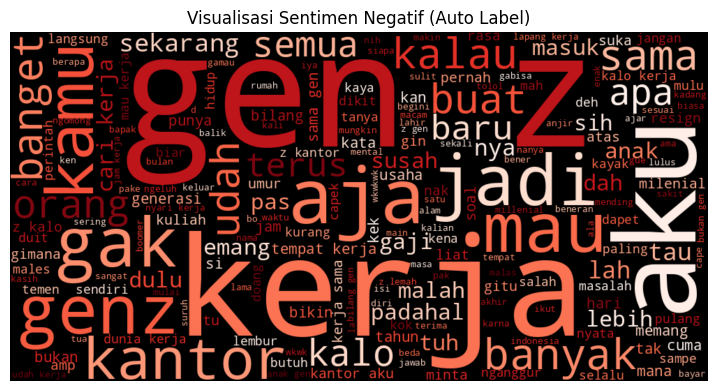

In [ ]:
# Automation
all_text_s0 = ' '.join(word for word in data_negatif['full_text'])
wordcloud = WordCloud(colormap='Reds', width=1000, height=500, mode='RGBA', background_color='black').generate(all_text_s0)

plt.figure(figsize=(9, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Visualisasi Sentimen Negatif (Auto Label)')
plt.margins(x=0, y=0)
plt.show()

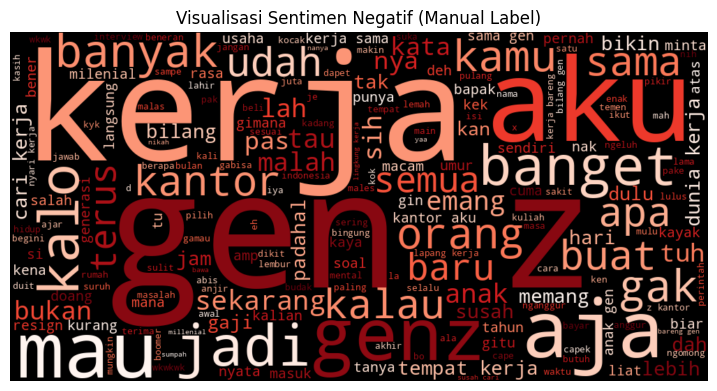

In [ ]:
# Manual
all_text_s0 = ' '.join(word for word in data_negatif2['full_text'])
wordcloud = WordCloud(colormap='Reds', width=1000, height=500, mode='RGBA', background_color='black').generate(all_text_s0)

plt.figure(figsize=(9, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Visualisasi Sentimen Negatif (Manual Label)')
plt.margins(x=0, y=0)
plt.show()

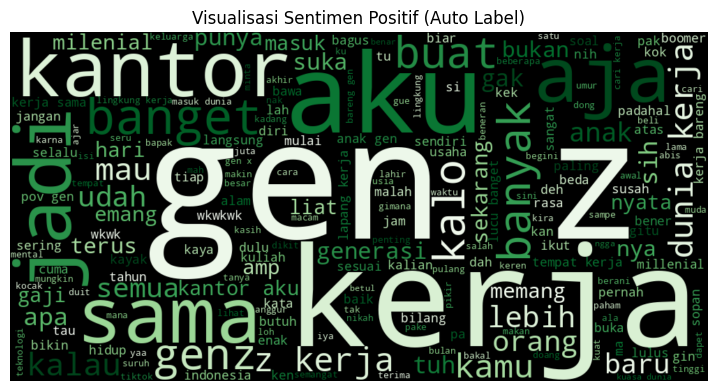

In [ ]:
# Automation
all_text_s1 = ' '.join(word for word in data_positif['full_text'])
wordcloud = WordCloud(colormap='Greens', width=1000, height=500, mode='RGBA', background_color='black').generate(all_text_s1)

plt.figure(figsize=(9, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Visualisasi Sentimen Positif (Auto Label)')
plt.margins(x=0, y=0)
plt.show()

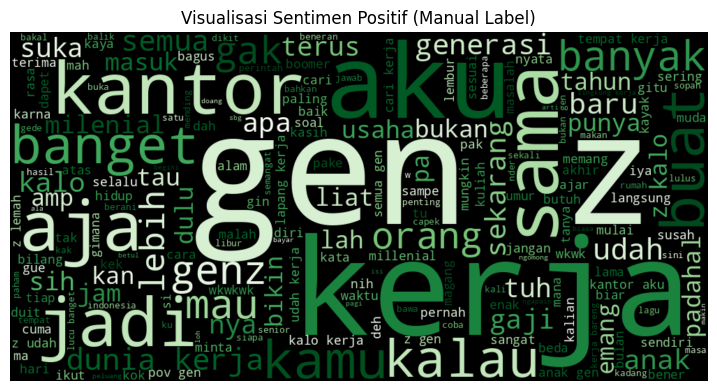

In [ ]:
# Manual
all_text_s1 = ' '.join(word for word in data_positif2['full_text'])
wordcloud = WordCloud(colormap='Greens', width=1000, height=500, mode='RGBA', background_color='black').generate(all_text_s1)

plt.figure(figsize=(9, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Visualisasi Sentimen Positif (Manual Label)')
plt.margins(x=0, y=0)
plt.show()

In [ ]:
# Hitung jumlah tiap sentimen Automation
data_auto['sentiment'].value_counts()

,count
sentiment,
NEGATIVE,1526
POSITIVE,972


In [ ]:
# Hitung jumlah tiap sentimen Manual
data_manual['sentiment'].value_counts()

,count
sentiment,
NEGATIVE,1268
POSITIVE,1230


#### Diagram Batang Sentimen

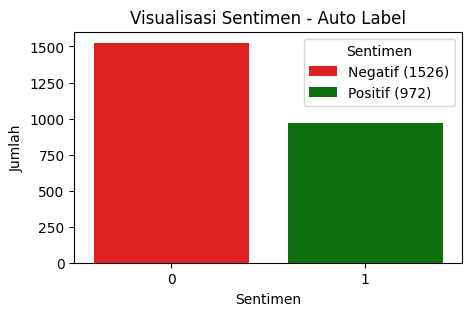

In [ ]:
# Auto
import warnings

# Mengabaikan FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

# Hitung jumlah data tiap sentimen Automation
sentiment_counts = data_auto['sentiment'].value_counts()

# Diagram batang
plt.figure(figsize=(5, 3))
ax = sns.countplot(data=data_auto, x='sentiment', hue='sentiment', palette={0: 'red', 1: 'green'})

# Menambah keterangan jumlah sentimen pada legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, [f'Negatif ({sentiment_counts[0]})', f'Positif ({sentiment_counts[1]})'],
          title='Sentimen', loc='upper right')

# Judul dan label
plt.title('Visualisasi Sentimen - Auto Label')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

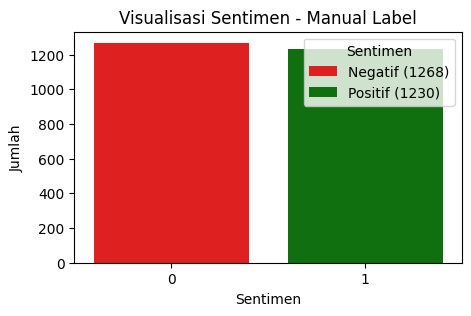

In [ ]:
# Manual
import warnings

# Mengabaikan FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

# Hitung jumlah data tiap sentimen Manual
sentiment_counts = data_manual['sentiment'].value_counts()

# Diagram batang
plt.figure(figsize=(5, 3))
ax = sns.countplot(data=data_manual, x='sentiment', hue='sentiment', palette={0: 'red', 1: 'green'})

# Menambah keterangan jumlah sentimen pada legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, [f'Negatif ({sentiment_counts[0]})', f'Positif ({sentiment_counts[1]})'],
          title='Sentimen', loc='upper right')

# Judul dan label
plt.title('Visualisasi Sentimen - Manual Label')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

### Visualisasi Kategori User

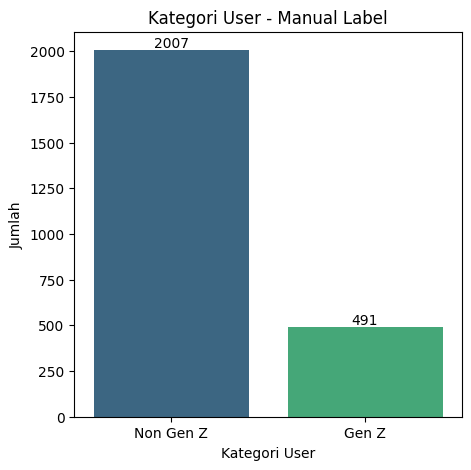

In [ ]:
# Load dataset Manual Label
df_manual = pd.read_csv("genz_kategoriManual.csv")  # Ganti dengan path file manual label

# Diagram Batang untuk Kategori User dengan jumlah label
def plot_user_category_with_counts(df, title):
    # Plot diagram batang
    plt.figure(figsize=(5, 5))
    ax = sns.countplot(x='Kategori_User', data=df, palette='viridis')

    # Menampilkan jumlah pada setiap batang
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2, height + 0.1, int(height), ha='center', va='bottom')

    plt.title(title)
    plt.xlabel('Kategori User')
    plt.ylabel('Jumlah')
    plt.show()

# Plot untuk dataset manual
plot_user_category_with_counts(df_manual, 'Kategori User - Manual Label')

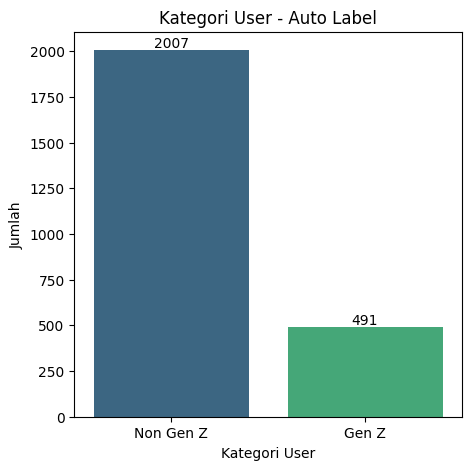

In [ ]:
# Load dataset Auto Label
df_auto = pd.read_csv("genz_kategoriAuto.csv")  # Ganti dengan path file auto label

# Diagram Batang untuk Kategori User dengan jumlah label
def plot_user_category_with_counts(df, title):
    # Plot diagram batang
    plt.figure(figsize=(5, 5))
    ax = sns.countplot(x='Kategori_User', data=df, palette='viridis')

    # Menampilkan jumlah pada setiap batang
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2, height + 0.1, int(height), ha='center', va='bottom')

    plt.title(title)
    plt.xlabel('Kategori User')
    plt.ylabel('Jumlah')
    plt.show()

# Plot untuk dataset auto
plot_user_category_with_counts(df_manual, 'Kategori User - Auto Label')

### Visualisasi Kategori Topik

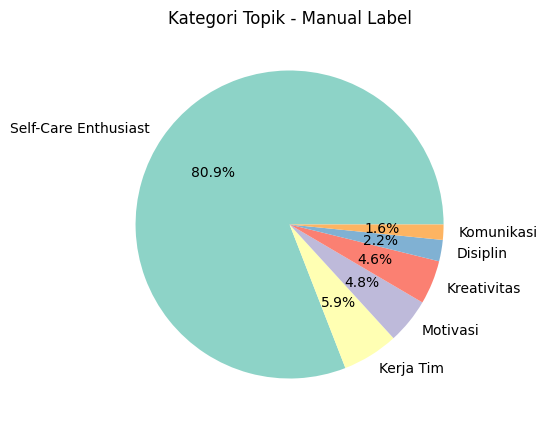

In [ ]:
# Load dataset Manual Label
df_manual = pd.read_csv("genz_kategoriManual.csv")  # Ganti dengan path file manual label

# Pie Chart untuk Kategori Topik
def plot_topic_category(df, title):
    # Hitung jumlah tiap kategori topik
    topic_counts = df['Kategori_Topik'].value_counts()

    plt.figure(figsize=(5,5))
    topic_counts.plot.pie(autopct='%1.1f%%', colors=sns.color_palette('Set3', len(topic_counts)))
    plt.title(title)
    plt.ylabel('')  # Menghilangkan label pada sumbu Y
    plt.show()

# Plot untuk dataset manual dan auto label
plot_topic_category(df_auto, 'Kategori Topik - Manual Label')

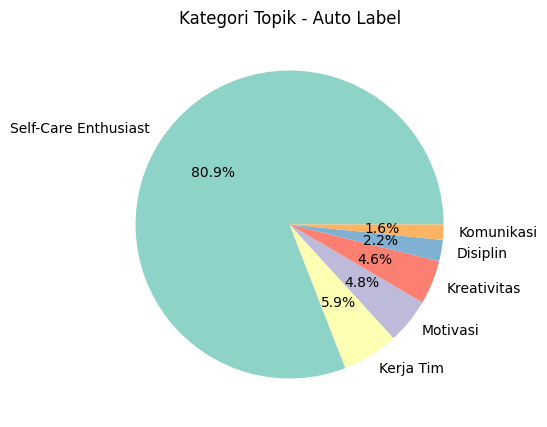

In [ ]:
# Load dataset Auto Label
df_manual = pd.read_csv("genz_kategoriAuto.csv")  # Ganti dengan path file auto label

# Pie Chart untuk Kategori Topik
def plot_topic_category(df, title):
    # Hitung jumlah tiap kategori topik
    topic_counts = df['Kategori_Topik'].value_counts()

    plt.figure(figsize=(5,5))
    topic_counts.plot.pie(autopct='%1.1f%%', colors=sns.color_palette('Set3', len(topic_counts)))
    plt.title(title)
    plt.ylabel('')  # Menghilangkan label pada sumbu Y
    plt.show()

# Plot untuk dataset manual dan auto label
plot_topic_category(df_auto, 'Kategori Topik - Auto Label')

# Ambil Data

In [ ]:
data_auto = pd.read_csv('genz_kategoriAuto.csv')
data_manual = pd.read_csv('genz_kategoriManual.csv')

# 5. Splitting Data

In [ ]:
# Memisahkan data latih dan data uji (Automation)
X_auto = data_auto['full_text']
y_auto = data_auto['sentiment']
X_train_auto, X_test_auto, y_train_auto, y_test_auto = train_test_split(X_auto, y_auto, test_size=0.25, random_state=1)

# Memisahkan data latih dan data uji (Manual)
X_manual = data_manual['full_text']
y_manual = data_manual['sentiment']
X_train_manual, X_test_manual, y_train_manual, y_test_manual = train_test_split(X_manual, y_manual, test_size=0.25, random_state=1)

In [ ]:
# Cek jumlah data setelah pemisahan
print("Jumlah data awal:", len(data_manual))
print("Jumlah data latih:", len(X_train_manual))
print("Jumlah data uji:", len(X_test_manual))

Jumlah data awal: 2498
Jumlah data latih: 1873
Jumlah data uji: 625


In [ ]:
# Cek jumlah data setelah pemisahan
print("Jumlah data awal:", len(data_auto))
print("Jumlah data latih:", len(X_train_auto))
print("Jumlah data uji:", len(X_test_auto))

Jumlah data awal: 2498
Jumlah data latih: 1873
Jumlah data uji: 625


# 6. Ekstraksi Fitur TF-IDF

In [ ]:
# Ekstraksi fitur dengan TF-IDF (Automation)
vectorizer_auto = TfidfVectorizer()
X_train_vec_auto = vectorizer_auto.fit_transform(X_train_auto)
X_test_vec_auto = vectorizer_auto.transform(X_test_auto)

# Ekstraksi fitur dengan TF-IDF (Manual)
vectorizer_manual = TfidfVectorizer()
X_train_vec_manual = vectorizer_manual.fit_transform(X_train_manual)
X_test_vec_manual = vectorizer_manual.transform(X_test_manual)

# 7. Oversampling

In [ ]:
# Melakukan SMOTE pada data Automation
smote = SMOTE(random_state=0)
X_train_resampled_auto, y_train_resampled_auto = smote.fit_resample(X_train_vec_auto, y_train_auto)

# Untuk data Manual tidak dilakukan oversampling karena antara data POSITIVE dan NEGATIVE sudah cukup seimbang

In [ ]:
# Visualisasi hasil SMOTE (Automation)
data_resampled_auto = pd.DataFrame({
    'full_text': X_train_auto[X_train_auto.index.isin(X_train_resampled_auto.indices)],
    'sentiment': y_train_resampled_auto
})

# Hitung hasil SMOTE
data_resampled_auto['sentiment'].value_counts()

,count
sentiment,
0.0,1132
1.0,1132


In [ ]:
# Buat DataFrame untuk data manual (tanpa SMOTE)
data_manual_final = pd.DataFrame({
    'full_text': X_train_manual,
    'sentiment': y_train_manual
})

# Hitung hasil NON SMOTE
data_manual_final['sentiment'].value_counts()

,count
sentiment,
0,948
1,925


# 8. Modeling

In [ ]:
# Melatih model Naive Bayes (Automation)
naive_bayes_auto = MultinomialNB()
naive_bayes_auto.fit(X_train_resampled_auto, y_train_resampled_auto)

MultinomialNB()

In [ ]:
# Melatih model Naive Bayes (Manual)
naive_bayes_manual = MultinomialNB()
naive_bayes_manual.fit(X_train_vec_manual, y_train_manual)

MultinomialNB()

# 9. Evaluasi

In [ ]:
# Evaluasi model untuk Automation
y_pred_auto = naive_bayes_auto.predict(X_test_vec_auto)
accuracy_auto = accuracy_score(y_test_auto, y_pred_auto)
classification_rep_auto = classification_report(y_test_auto, y_pred_auto, target_names=['negatif', 'positif'])

print('Akurasi Model Naive Bayes (Automation): ', accuracy_auto)
print('\nLaporan Klasifikasi (Automation): \n', classification_rep_auto)

Akurasi Model Naive Bayes (Automation):  0.7008

Laporan Klasifikasi (Automation): 
               precision    recall  f1-score   support

     negatif       0.77      0.75      0.76       394
     positif       0.59      0.62      0.60       231

    accuracy                           0.70       625
   macro avg       0.68      0.68      0.68       625
weighted avg       0.70      0.70      0.70       625



In [ ]:
# Evaluasi model untuk Manual
y_pred_manual = naive_bayes_manual.predict(X_test_vec_manual)
accuracy_manual = accuracy_score(y_test_manual, y_pred_manual)
classification_rep_manual = classification_report(y_test_manual, y_pred_manual, target_names=['negatif', 'positif'])

print('Akurasi Model Naive Bayes (Manual): ', accuracy_manual)
print('\nLaporan Klasifikasi (Manual): \n', classification_rep_manual)

Akurasi Model Naive Bayes (Manual):  0.6752

Laporan Klasifikasi (Manual): 
               precision    recall  f1-score   support

     negatif       0.66      0.76      0.71       320
     positif       0.70      0.58      0.64       305

    accuracy                           0.68       625
   macro avg       0.68      0.67      0.67       625
weighted avg       0.68      0.68      0.67       625



# 10. Ekspor Model & Vectorizer

In [ ]:
import pickle

# Ekspor model dan vectorizer untuk Automation
with open('model_auto.pkl', 'wb') as model_file:
    pickle.dump(naive_bayes_auto, model_file)

with open('vec_auto.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer_auto, vectorizer_file)

# Ekspor model dan vectorizer untuk Manual
with open('model_manual.pkl', 'wb') as model_file:
    pickle.dump(naive_bayes_manual, model_file)

with open('vec_manual.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer_manual, vectorizer_file)

In [ ]:
from google.colab import files

# Mengunduh file pickle untuk Automation
files.download('model_auto.pkl')
files.download('vec_auto.pkl')

# Mengunduh file pickle untuk Manual
files.download('model_manual.pkl')
files.download('vec_manual.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>